In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import scipy as scp
import pandas as pd
import copy as cp
from tqdm import tqdm 

sns.set_theme(style="darkgrid",context='talk', font_scale=1.1)
%matplotlib inline

import numpy as np

In [ ]:
fec_data = {}

In [143]:
class Population(object):
    
    def __init__(self, n0, r0, α, β, θ, c, growth_r, strain='A', diet='OP50'):
        self.pop = n0
        self.resource = r0
        self.α = α
        self.β = β
        self.θ = θ # resource inflow rate
        self.cons = c #consumption parameter
        self.growth_r = growth_r
        self.strain = strain
        self.diet = diet
        self.set_fec_mat()
              
    def set_fec_mat(self, f_val=100):
        F = np.identity(5) * 0
        F[0][3] = 0.15*f_val #0.15 is the transition rate between RA -> OA
        self.F_mat = F
        
        
    def init_history(self):
        """Initialize the history dictionary 
        """
        self.history = {'pop':[], 'R':[]}
    
    def update_history(self):
        self.history['pop'].append(self.pop)
        self.history['R'].append(self.resource_density)
        
    @property
    def resource_density(self):
        return self.resource/self.consumers
        
    @property
    def consumers(self):
        return np.sum(self.pop[1] + self.pop[3:])
        
    @property
    def fund_mat(self):
        return np.linalg.inv(np.identity(5) - self.tranistion_matrix)

    
    @property
    def tranistion_matrix(self):
        resource_density = self.resource_density
        γ_JE  = 1
        γ_RAJ = lambda r: 0.5*r/(self.α + r) if 0.5*r/(self.α + r) >=0 else 0.0
        γ_OR = 0.15
        γ_DJ = lambda r: self.β/(self.α + r)
        γ_RAD = lambda r: 0.5*r/(self.α + r) if 0.5*r/(self.α + r) >= 0.0 else 0.0
        δ_E = lambda r: 0.99*r/(self.α + r) if 0.5*r/(self.α + r) >=0.2 else 0.2
        δ_J = lambda r: 0.99*r/(self.α + r) if 0.5*r/(self.α + r) >=0.2 else 0.2
        δ_RA = lambda r: 0.99*r/(self.α + r) if 0.5*r/(self.α + r) >=0.2 else 0.2
        δ_OA = lambda r: 0.99*r/(self.α + r) if 0.5*r/(self.α + r) >=0.2 else 0.2
        δ_D = 0.99
        U_mat = np.matrix([[δ_E(resource_density)*(1 - γ_JE),                                                        0,                              0,               0,    0],
                          [δ_E(resource_density)*γ_JE, δ_J(resource_density)*(1 - γ_RAJ(resource_density))*(1 - γ_DJ(resource_density)),                              0,               0,    0],
                          [              0,                                  δ_J(resource_density)*γ_DJ(resource_density), δ_D*(1 - γ_RAD(resource_density)),               0,    0],
                          [              0,                                  δ_J(resource_density)*γ_RAJ(resource_density),      δ_D*γ_RAD(resource_density), δ_RA(resource_density)*(1 - γ_OR),    0],
                          [              0,                                                         0,                             0,       δ_RA(resource_density)*γ_OR, δ_OA(resource_density)]])
        return U_mat
    
    def get_next_gen(self):
        self.pop = np.array(np.matmul(self.tranistion_matrix + self.F_mat, self.pop))
        resource = self.growth_r * self.resource + self.θ - self.cons*self.consumers*self.resource
        if resource >= 0:
            self.resource =  resource
        else:
            self.resource = 0.0
        
        
    def simulate(self, t):
        self.init_history()
        self.update_history()
        for i in range(t):
            self.get_next_gen()
            self.update_history()

In [144]:
n0 = np.array([[0], [50], [0], [0], [0]])
r0 = 100
α = 0.4
β = 0.2
θ = 10
c = 0.2

test = Population(n0, r0, α, β, θ, c, 2)

In [145]:
test.simulate(20)

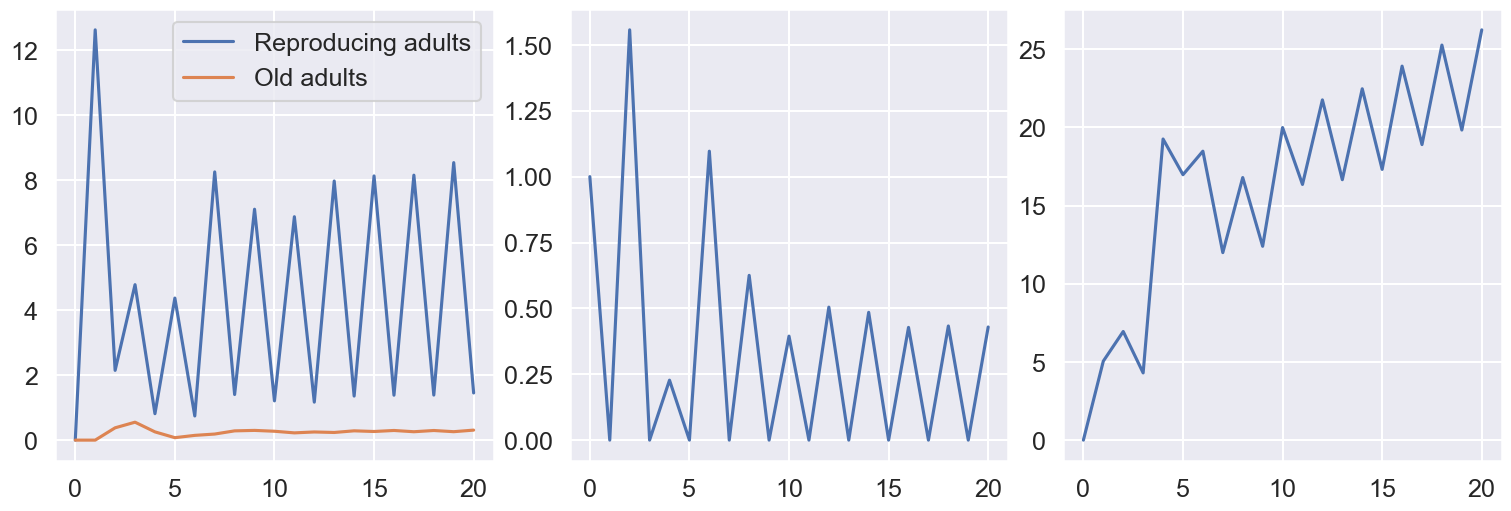

In [146]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(15, 5),
    constrained_layout=True)

axes = axes.flatten()

# for i,j in zip(range(4), ['E', 'J', 'RA', 'OA']):
#     plt.plot([m[i][0] for m in n_list], label=j)

# axes[0].plot(np.cumsum([m[0][0] for m in test.history['pop']]), label='Eggs')
#axes[0].plot([m[1][0] for m in test.history['pop']], label='Juveniles')
axes[0].plot([m[3][0] for m in test.history['pop']], label='Reproducing adults')
axes[0].plot([m[4][0] for m in test.history['pop']], label='Old adults')
    
axes[1].plot(test.history['R'])


#axes[1].set_yscale('log')


axes[2].plot([m[2][0] for m in test.history['pop']])
    
axes[0].legend()

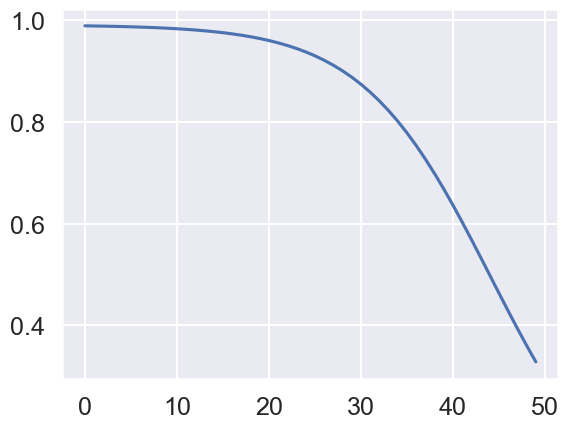

In [167]:
γ_DJ = lambda d:np.divide(0.99, 1 + np.exp(-1*0.7*(d - 1)))
pop_size=100
plt.plot([γ_DJ(i/pop_size) for i in np.linspace(1000, 0, 50)])

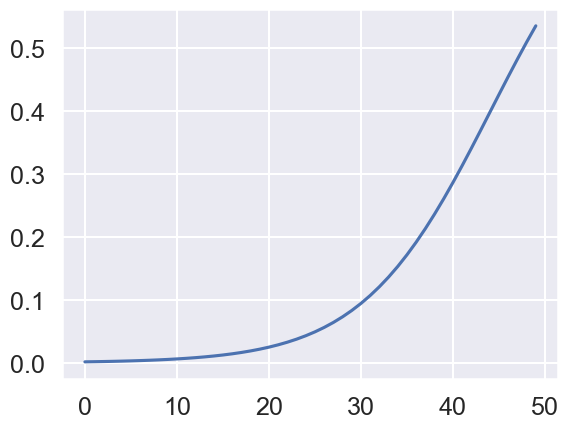

In [156]:
γ_DJ = lambda d:np.divide(0.8, 1 + np.exp(1*0.7*(d - 1)))
pop_size=100
plt.plot([γ_DJ(i/pop_size) for i in np.linspace(1000, 0, 50)])

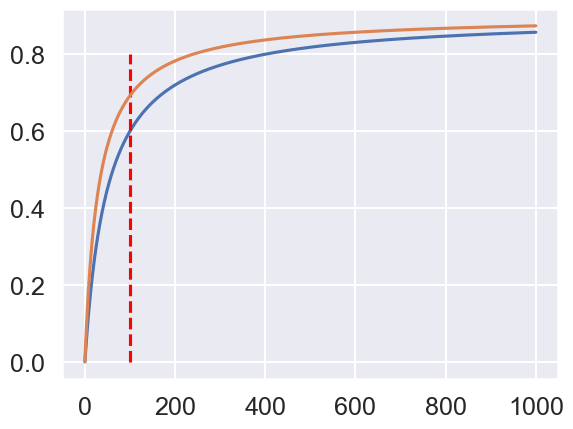

In [161]:
rate = 0.9
α = 0.5
pop = 100
plt.plot(np.linspace(1000, 0, 1000), [rate * np.divide(i/pop, α + i/pop) for i in np.linspace(1000, 0, 1000)])
plt.vlines(100, 0, 0.8, ls='dashed', color='red')

α = 0.3
pop = 100
plt.plot(np.linspace(1000, 0, 1000), [rate * np.divide(i/pop, α + i/pop) for i in np.linspace(1000, 0, 1000)])



In [163]:
rate

0.9

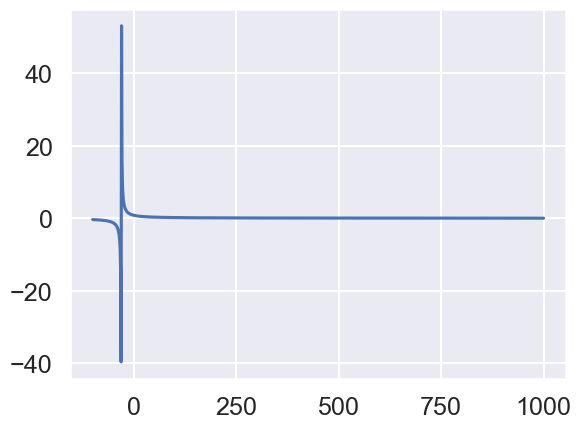

In [170]:
α = 0.3
pop = 100
plt.plot(np.linspace(1000, -100, 1000), [np.divide(0.25, α + i/pop) for i in np.linspace(1000, -100, 1000)])

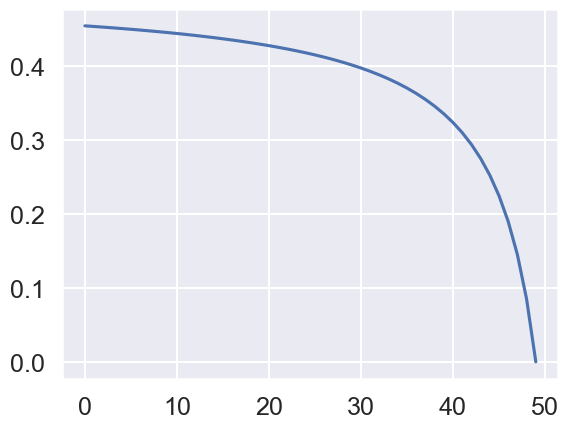

In [133]:
rate = 0.5
α = 1
pop = 100
plt.plot([rate*(i/pop)/(α + (i/pop)) for i in np.linspace(1000, 0)])

In [117]:
test.simulate(10)

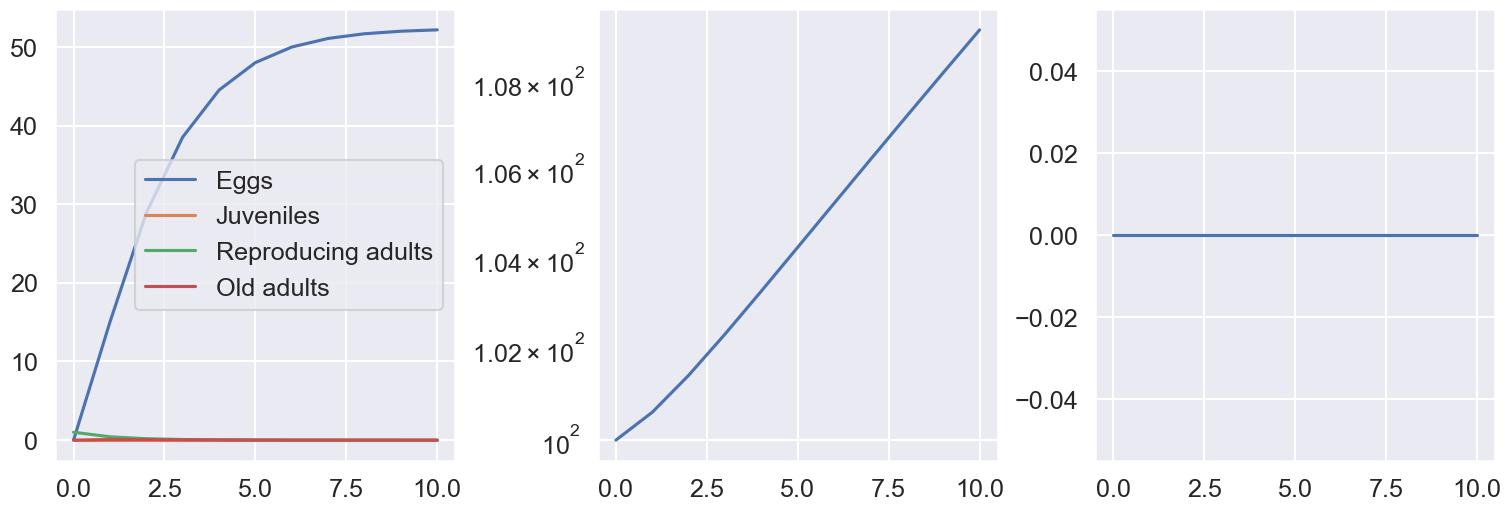

In [118]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(15, 5),
    constrained_layout=True)

axes = axes.flatten()

# for i,j in zip(range(4), ['E', 'J', 'RA', 'OA']):
#     plt.plot([m[i][0] for m in n_list], label=j)

axes[0].plot(np.cumsum([m[0][0] for m in test.history['pop']]), label='Eggs')
axes[0].plot([m[1][0] for m in test.history['pop']], label='Juveniles')
axes[0].plot([m[3][0] for m in test.history['pop']], label='Reproducing adults')
axes[0].plot([m[4][0] for m in test.history['pop']], label='Old adults')
    
axes[1].plot(test.history['R'])


axes[1].set_yscale('log')


axes[2].plot([m[2][0] for m in test.history['pop']])
    
axes[0].legend()

In [172]:
[rate * np.divide(i/pop, α + i/pop) for i in np.linspace(1000, 0, 10)]

[0.8737864077669902,
 0.8706166868198306,
 0.8665749656121045,
 0.861244019138756,
 0.8538899430740039,
 0.8430913348946136,
 0.8256880733944955,
 0.7929515418502203,
 0.7086614173228346,
 0.0]

In [189]:
γ_RAJ = lambda d:  β/(α + d) if 0.5*d/(α + d) >=0 else 0.0

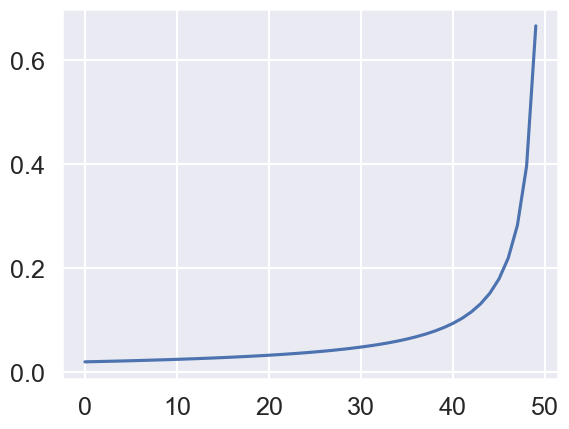

In [191]:
pop_size = 100
α = 0.3
β = 0.2
plt.plot([γ_RAJ(i/pop_size) for i in np.linspace(1000, 0, 50)])

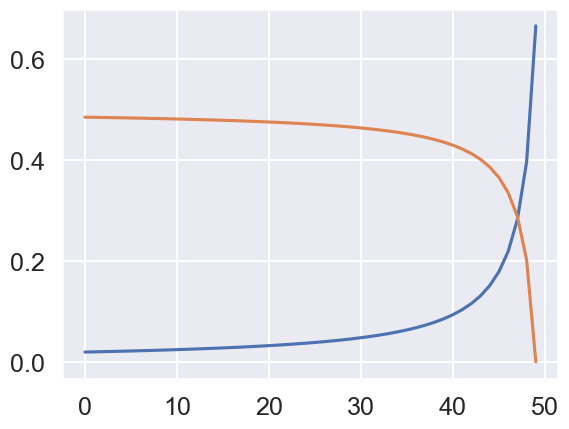

In [196]:
pop_size = 100
α = 0.3
β = 0.2

γ_DJ = lambda r: β/(α + r)
γ_RAD = lambda r: 0.5*r/(α + r) if 0.5*r/(α + r) >= 0.0 else 0.0
plt.plot([γ_DJ(i/pop_size) for i in np.linspace(1000, 0, 50)])
plt.plot([γ_RAD(i/pop_size) for i in np.linspace(1000, 0, 50)])

In [168]:
def simp_consum_resource(n0, r0, α, β, θ, c, r_growth, t):
    γ_JE  = 1
    γ_RAJ = lambda d:np.divide(0.5, 1 + np.exp(-1*0.7*(d - 1))) #0.5*r/(α + r) if 0.5*r/(α + r) >=0 else 0.0
    γ_OR = 0.15
    γ_DJ = lambda d:np.divide(0.5, 1 + np.exp(1*0.7*(d - 1)))
    γ_RAD = lambda d:np.divide(0.5, 1 + np.exp(-1*0.7*(d - 1)))
    
    δ_E = lambda d:np.divide(0.99, 1 + np.exp(-1*0.7*(d - 1)))
    δ_J = lambda d:np.divide(0.99, 1 + np.exp(-1*0.7*(d - 1)))
    δ_RA = lambda d:np.divide(0.99, 1 + np.exp(-1*0.7*(d - 1)))
    δ_OA = lambda d:np.divide(0.99, 1 + np.exp(-1*0.7*(d - 1)))
    δ_D = 0.99
    F = np.identity(5) * 0
    F[0][3] =γ_OR*100
    n_list = []
    r_list = []
    R0_list = []
    consump = []
    total_eggs = 0
    for i in range(t):
        d0 = r0/np.sum(n0[1] + n0[3:])
        U_simp = np.matrix([[δ_E(d0)*(1 - γ_JE),                          0,               0,               0,    0],
                            [      δ_E(d0)*γ_JE, δ_J(d0)*(1 - γ_RAJ(d0))*(1 - γ_DJ(d0)),               0,               0,    0],
                            [             0,                   δ_J(d0)*γ_DJ(d0), δ_D*(1 - γ_RAD(d0)),               0,    0],
                            [             0,                  δ_J(d0)*γ_RAJ(d0),       δ_D*γ_RAD(d0), δ_RA(d0)*(1 - γ_OR),    0],
                            [             0,                          0,               0,       δ_RA(d0)*γ_OR, δ_OA(d0)]])
        n0 = np.array(np.matmul(U_simp + F, n0))
        r0 = r_growth*r0 + θ - c*np.sum(n0[1] + n0[3:])       
        if r0 < 0:
            r0 = 0
        n_list.append(n0)
        r_list.append(r0)
        consump.append(c*np.sum(n0[1] + n0[3:]))
        fund_mat = np.linalg.inv(np.identity(5) - U_simp)
        R0_list.append(np.linalg.eig(F*fund_mat))
    return n_list, r_list, R0_list, consump

In [178]:
n0 = np.array([[0], [0], [0], [1], [0]])
r0 = 1000
α = 0.3
β = 0.2
r_growth = 0
θ = 0
c = 0.5
test = simp_consum_resource(n0, r0, α, β, θ, c, r_growth, 30)

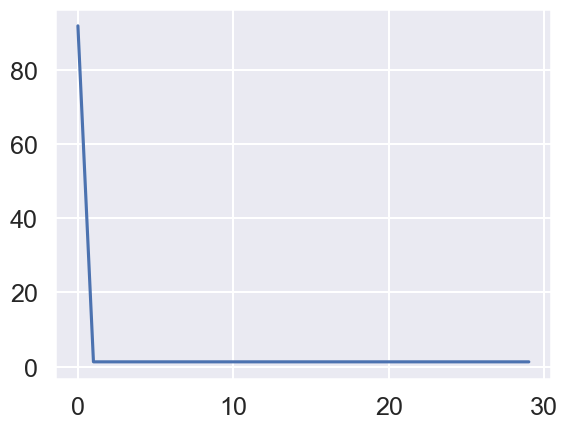

In [179]:
plt.plot([i[0][0] for i in test[2]])

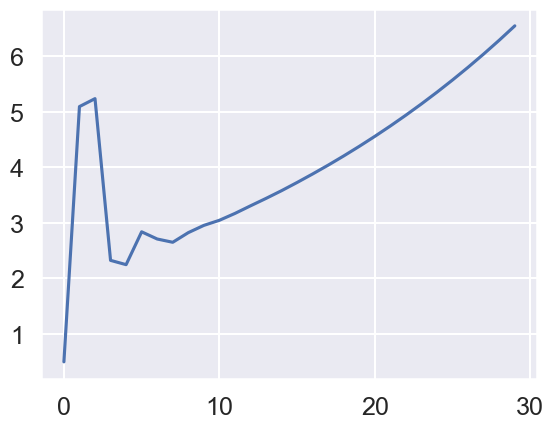

In [180]:
plt.plot(test[3])

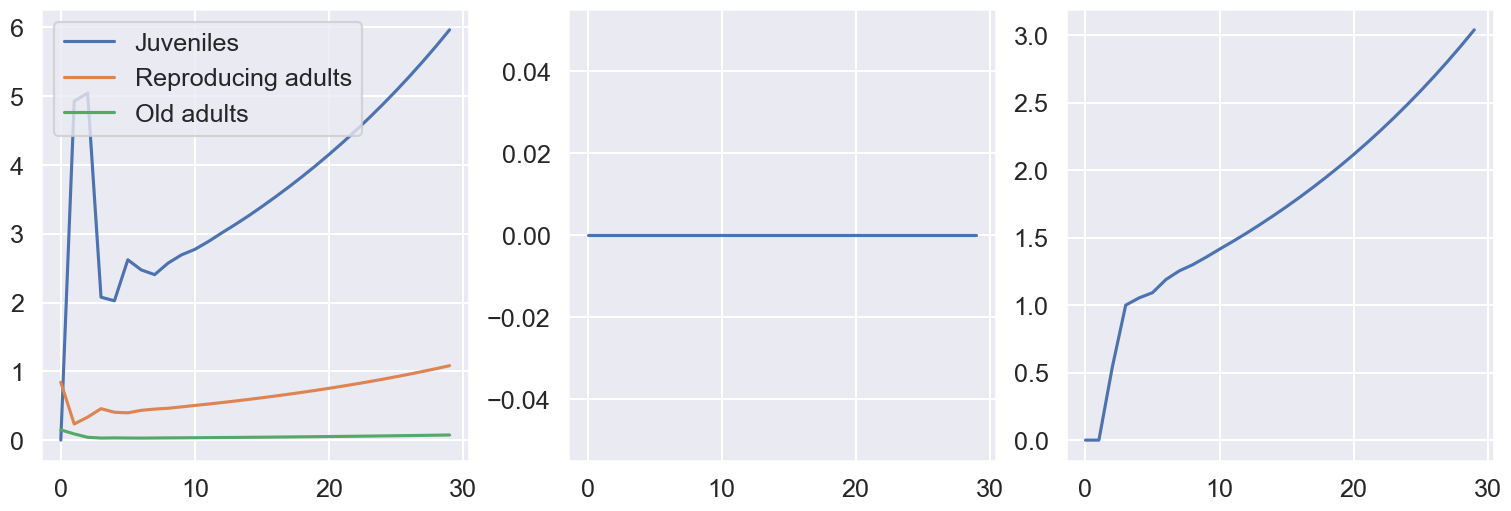

In [181]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(15, 5),
    constrained_layout=True)

axes = axes.flatten()

# for i,j in zip(range(4), ['E', 'J', 'RA', 'OA']):
#     plt.plot([m[i][0] for m in n_list], label=j)

# axes[0].plot([m[0][0] for m in test[0]], label='Eggs')
axes[0].plot([m[1][0] for m in test[0]], label='Juveniles')
axes[0].plot([m[3][0] for m in test[0]], label='Reproducing adults')
axes[0].plot([m[4][0] for m in test[0]], label='Old adults')
    
axes[1].plot(test[1])


# axes[1].set_yscale('log')


axes[2].plot([m[2][0] for m in test[0]])
    
axes[0].legend()